In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import os
import sys
relative_path = "../__Fitting_Drivers/"
absolute_path = os.path.abspath(relative_path)

sys.path.append(absolute_path)
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 18
})


# Load and filter data

In [2]:
test_data = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V5-short.xlsx', index_col=0)
test_data.reset_index(drop=True, inplace=True)

In [3]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

# Surrogate model train

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [5]:
from sklearn.neural_network import MLPRegressor
import pickle
from Scaler_driver import DataScaler as DS

# Integrated model training

In [6]:
df_raw = pd.read_csv('../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_1000.csv', index_col=0, encoding='ISO-8859-1')
df_raw.reset_index(drop=True, inplace=True)


In [7]:
scaler = DS()
scaled_df = scaler.fit_transform(df_raw, x_cols, y_cols)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_cols], scaled_df[y_cols], train_size=0.7, random_state=42)

In [9]:
regr = MLPRegressor(hidden_layer_sizes = (100,), activation = 'relu', random_state=42, max_iter=300, learning_rate = 'adaptive')
regr.fit(X_train, y_train)

MLPRegressor(learning_rate='adaptive', max_iter=300, random_state=42)

In [10]:
regr.predict(X_test)
regr.score(X_test, y_test)

0.9848857515612569

In [11]:
from sklearn.neural_network import MLPRegressor

import joblib
import os

def save_model(model, x_cols, y_cols, scaler, path='Models/', filename='mlp_model.joblib'):
    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)
    
    # Save model and metadata together
    model_data = {
        'model': model,
        'x_cols': x_cols,
        'y_cols': y_cols,
        'scaler': scaler
    }
    
    joblib.dump(model_data, os.path.join(path, filename))
    print(f"Model saved to {os.path.join(path, filename)}")

def load_model(path='Models/mlp_model.joblib'):
    # Load model and metadata
    model_data = joblib.load(path)
    
    model = model_data['model']
    x_cols = model_data['x_cols']
    y_cols = model_data['y_cols']
    scaler = model_data['scaler']
    
    print(f"Model loaded from {path}")
    return model, x_cols, y_cols, scaler

In [12]:
# Save the model
save_model(regr, x_cols=x_cols, y_cols=y_cols, 
           scaler=scaler, path = '../00_Modell_database/Sklearnmodelbig', filename='sklearnann.joblib')

Model saved to ../00_Modell_database/Sklearnmodelbig\sklearnann.joblib


# Load back the model

In [13]:
# Later, load the model
loaded_mlp, x_cols, y_cols, loaded_scaler = load_model('../00_Modell_database/Sklearnmodelbig/sklearnann.joblib')

Model loaded from ../00_Modell_database/Sklearnmodelbig/sklearnann.joblib


In [14]:
loaded_mlp.predict(X_test)
loaded_mlp.score(X_test, y_test)

0.9848857515612569

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_raw[x_cols], df_raw[y_cols], train_size=0.7, random_state=42)

train_sc = loaded_scaler.x_scaler.transform(X_train)
train_full_sc = loaded_scaler.x_scaler.transform(df_raw[x_cols])
test_sc = loaded_scaler.x_scaler.transform(X_test)
valid_sc = loaded_scaler.x_scaler.transform(test_data[x_cols])

pred_train = loaded_mlp.predict(train_sc)
pred_train_full = loaded_mlp.predict(train_full_sc)
pred_test = loaded_mlp.predict(test_sc)
pred_valid = loaded_mlp.predict(valid_sc)

train_y_pred = loaded_scaler.y_scaler.inverse_transform(pred_train)
train_full_y_pred = loaded_scaler.y_scaler.inverse_transform(pred_train_full)
test_y_pred = loaded_scaler.y_scaler.inverse_transform(pred_test)
valid_y_pred = loaded_scaler.y_scaler.inverse_transform(pred_valid)

train_pred_df = pd.DataFrame(train_y_pred, columns=y_cols)
train_full_y_pred = pd.DataFrame(train_full_y_pred, columns=y_cols)
test_pred_df = pd.DataFrame(test_y_pred, columns=y_cols)
valid_pred_df = pd.DataFrame(valid_y_pred, columns=y_cols)

c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [16]:
y_cols

['PROD1E1IN', 'PROD1OUT', 'FEED1E1OUT', 'FEED1OUT']

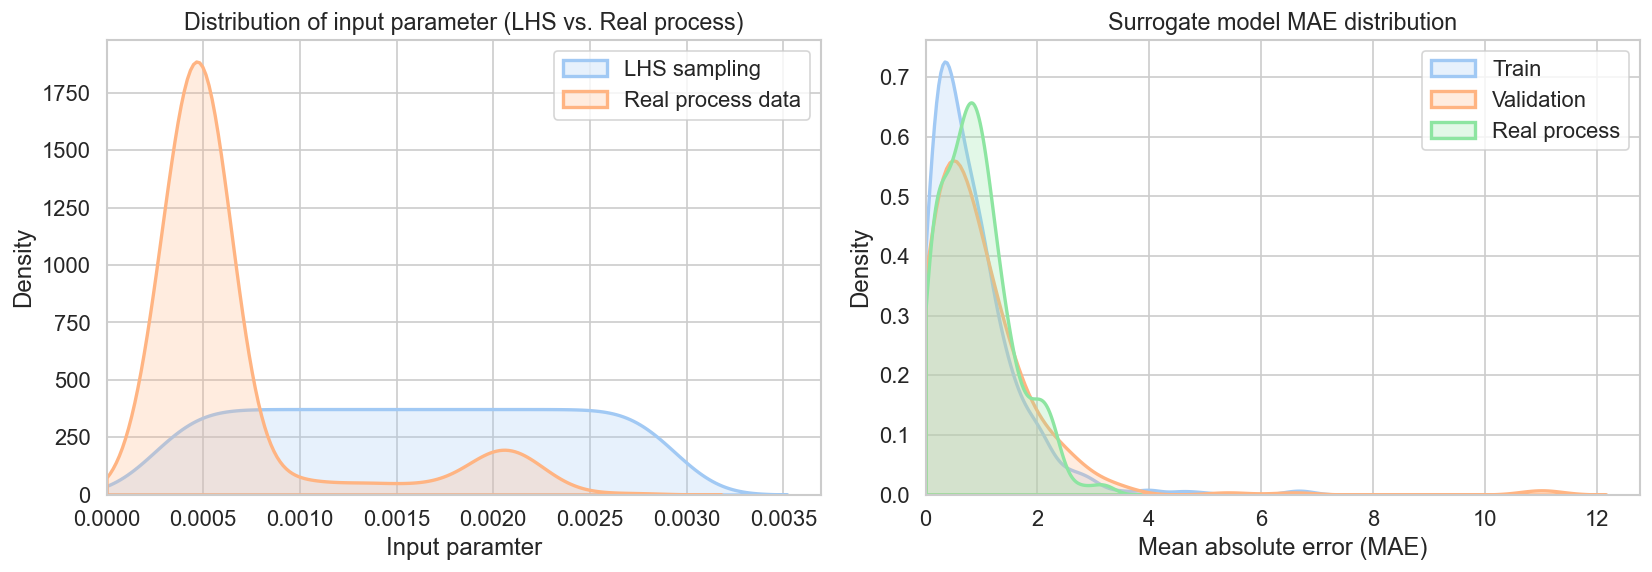

In [17]:
import seaborn as sns
# Set Seaborn style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Ensure matching columns and index alignment
mae_train = abs(y_train['FEED1E1OUT'].values - train_pred_df['FEED1E1OUT'].values)
mae_valid = abs(y_test['FEED1E1OUT'].values - test_pred_df['FEED1E1OUT'].values)
mae_real  = abs(test_data['FEED1E1OUT'].values - valid_pred_df['FEED1E1OUT'].values)

# Convert to Series
mae_train = pd.Series(mae_train)
mae_valid = pd.Series(mae_valid)
mae_real  = pd.Series(mae_real)

# Drop any NaNs
mae_train = mae_train.dropna()
mae_valid = mae_valid.dropna()
mae_real  = mae_real.dropna()

# Combine into DataFrame
mae_df = pd.DataFrame({
    'MAE': pd.concat([mae_train, mae_valid, mae_real], ignore_index=True),
    'Dataset': (['Train'] * len(mae_train)) + 
               (['Validation'] * len(mae_valid)) + 
               (['Real Process'] * len(mae_real))
})

# --- Create figure ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# --- Subplot 1: E1FOULING Drift ---
sns.kdeplot(df_raw['E1FOULING'], label='LHS sampling', ax=axes[0], fill=True, linewidth=2, clip=(0, None))
sns.kdeplot(test_data['E1FOULING'], label='Real process data', ax=axes[0], fill=True, linewidth=2,  clip=(0, None))
axes[0].set_title('Distribution of input parameter (LHS vs. Real process)', fontsize=14)
axes[0].set_xlabel('Input paramter')
axes[0].set_ylabel('Density')
axes[0].set_xlim(left=0)
axes[0].legend()

# --- Subplot 2: MAE Distribution ---
#sns.kdeplot(data=mae_df, x='MAE', hue='Dataset', ax=axes[1], fill=True, linewidth=2)
sns.kdeplot(mae_train, label='Train', ax=axes[1], fill=True, linewidth=2, clip=(0, None))
sns.kdeplot(mae_valid, label='Validation', ax=axes[1], fill=True, linewidth=2, clip=(0, None))
sns.kdeplot(mae_real, label='Real process', ax=axes[1], fill=True, linewidth=2, clip=(0, None))

axes[1].set_title('Surrogate model MAE distribution', fontsize=14)
axes[1].set_xlabel('Mean absolute error (MAE)')
axes[1].set_ylabel('Density')
axes[1].set_xlim(left=0)  # Optional but adds certainty
axes[1].legend()

# --- Finalize plot ---
plt.tight_layout()
plt.show()